#### Maps of surface precipitation in prognostic runs for baseline physics, RF, and NN ensemble

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

import cftime
import intake
import fsspec
import numpy as np
import pandas as pd
import seaborn as sb
import xarray as xr

import fv3viz as viz
from vcm.catalog import catalog

def weighted_average(array, weights, axis=None):
    return np.nansum(array * weights, axis=axis) / np.nansum(weights, axis=axis)


MAPPABLE_VAR_KWARGS = {
    "coord_x_center": "x",
    "coord_y_center": "y",
    "coord_x_outer": "x_interface",
    "coord_y_outer": "y_interface",
    "coord_vars": {
        "lonb": ["y_interface", "x_interface", "tile"],
        "latb": ["y_interface", "x_interface", "tile"],
        "lon": ["y", "x", "tile"],
        "lat": ["y", "x", "tile"],
    },
}

with fsspec.open("gs://vcm-ml-public/argo/prog-report-2021-05-14-nn-rf-40day/NN-ensemble-median/diags.nc", "rb") as f:
    diags_nn = xr.open_dataset(f).load()
    
with fsspec.open("gs://vcm-ml-public/argo/prog-report-2021-05-14-nn-rf-40day/RF/diags.nc", "rb") as f:
    diags_rf = xr.open_dataset(f).load()
    
with fsspec.open("gs://vcm-ml-public/argo/prog-report-2021-05-14-nn-rf-40day/baseline/diags.nc", "rb") as f:
    diags_baseline = xr.open_dataset(f).load()
    
    
grid = catalog["grid/c48"].read()
area = grid["area"]

land_sea_mask = catalog["landseamask/c48"].read()["land_sea_mask"]

#### RMSE maps (reproduces the prognostic report)

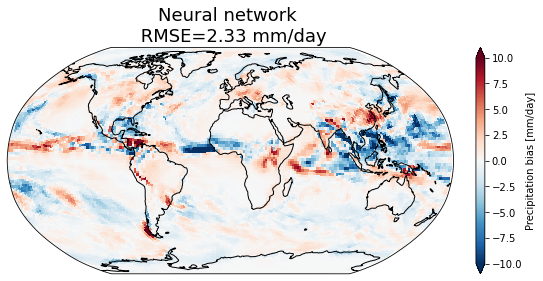

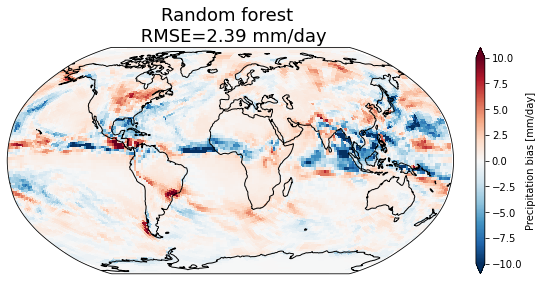

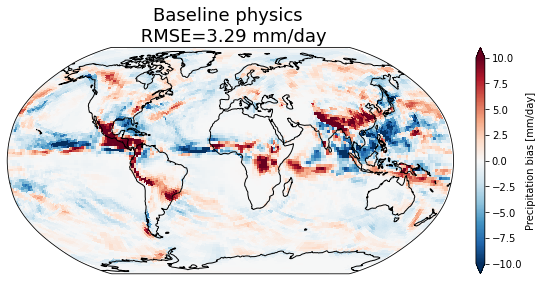

In [3]:
var = "total_precip_to_surface_time_mean_bias"
vmax = 10
fig_size = (8,5)

labels = ["Neural network", "Random forest", "Baseline physics"]
datasets = [diags_nn, diags_rf, diags_baseline]

for label, ds in zip(labels, datasets):
    mappable_var = viz.mappable_var(ds, var, **MAPPABLE_VAR_KWARGS)
    
    rmse = np.sqrt(weighted_average(ds[var]**2, area))
    bias = weighted_average(ds[var], area)
    
    fig, _, _, _, _ = viz.plot_cube(
        mappable_var,
        vmax=vmax,
        cbar_label="Precipitation bias [mm/day]",
    )
    
    fig.set_size_inches(fig_size)
    
    title = f"{label} \n RMSE={rmse:3.2f} mm/day"
    plt.title(title, fontsize=18)
    plt.savefig(f"figures/prognostic-sfc-precip-rmse-map-{label.replace(' ', '-').lower()}.png", bbox_inches = "tight")
    plt.show()
    

#### Bar plot for domain averages of precip bias and RMSE

In [ ]:
verif_physics =  standardize_fv3_diagnostics(catalog['40day_c48_gfsphysics_15min_may2020'].to_dask())
verif_physics["total_precip_to_surface"] = verif_physics["PRATEsfc"] * SECONDS_PER_DAY

In [7]:
var= "total_precip_to_surface_time_mean_bias"

domain_avg_biases = []

labels = ["baseline", "neural network", "random forest"]
datasets = [diags_baseline, diags_nn, diags_rf]

for domain in ["global", "land", "ocean"]:
    for label, ds in zip(labels, datasets):
        if domain == "global":
            area_masked = area
            da = ds[var]
        elif domain == "land":
            area_masked = area.where(land_sea_mask==1)
            da = ds[var].where(land_sea_mask==1)
        elif domain == "ocean":
            area_masked = area.where(land_sea_mask==0)
            da = ds[var].where(land_sea_mask==0)            
        bias = ((da * area_masked).sum(skipna=True, dim=["tile", "x", "y"]) / area_masked.sum(skipna=True)).item()
        rmse = np.sqrt( 
            (da**2 * area_masked).sum(skipna=True, dim=["tile", "x", "y"]) / area_masked.sum(skipna=True)
        ).item()        
        domain_avg_biases.append([domain, label, rmse, bias])
        
biases = pd.DataFrame(domain_avg_biases, columns=["domain", "dataset", "RMSE", "bias"])


In [8]:
biases = pd.DataFrame(domain_avg_biases, columns=["domain", "dataset", "RMSE", "bias"])
biases

,domain,dataset,RMSE,bias
0,global,baseline,3.288139,-0.103885
1,global,neural network,2.329524,-0.194569
2,global,random forest,2.390241,-0.047806
3,land,baseline,4.178438,0.967052
4,land,neural network,2.008006,0.227413
5,land,random forest,2.091090,0.317407
6,ocean,baseline,2.931559,-0.555902
7,ocean,neural network,2.515020,-0.370797
8,ocean,random forest,2.574048,-0.209359


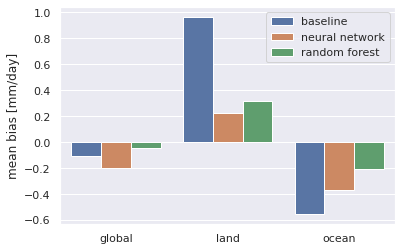

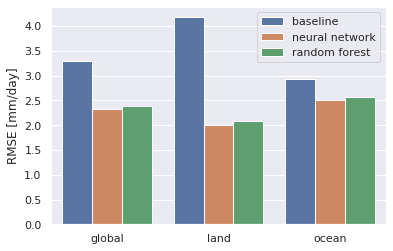

In [10]:

sb.set(font_scale = 1)


biases = pd.DataFrame(domain_avg_biases, columns=["domain", "dataset", "RMSE", "bias"])

fig = plt.figure()
f = sb.barplot(
    x="domain", 
    y="bias", 
    hue="dataset", 
    data=biases,
)
f.set_xlabel("", fontsize=20)
f.set_ylabel("mean bias [mm/day]")
f.legend(loc="upper right")
fig.savefig(f"figures/prognostic_sfc_precip_bias_bar_plot.png")


fig = plt.figure()
f = sb.barplot(
    x="domain", 
    y="RMSE", 
    hue="dataset", 
    data=biases,
)
f.set_xlabel("", fontsize=20)
f.set_ylabel("RMSE [mm/day]")
f.legend(loc="upper right")
fig.savefig(f"figures/prognostic_sfc_precip_rmse_bar_plot.png")